# The GUI

This is going to be where I write the GUI classes which will include interactivity as well as visualisation.

In [1]:
import tkinter as tk
from tkinter import messagebox
import tkinter.ttk as ttk
from tkinter.filedialog import asksaveasfile
from matplotlib import pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns
import os
import re

import pandas as pd
import numpy as np

%run pickling_db_funcs.ipynb

In [2]:
DATA_FOLDER = DATA_FOLDER
CSV_FOLDER = os.path.join(DATA_FOLDER, 'csv')
JSON_FOLDER = os.path.join(DATA_FOLDER, 'json')
PICKLE_FOLDER = os.path.join(DATA_FOLDER, 'pickle')

class ApplicationBase:
    def __init__(self):
        self.root = tk.Tk()
        self.root.title('Summative Assessment')
        self.root.state('zoomed')

        # State management
        self.frames = {}

        self.root.grid_columnconfigure(1, weight=1)
        self.root.grid_rowconfigure(1, weight=1)

        self.setup()
    
    def setup(self):
        # Create file directories
        os.makedirs(CSV_FOLDER, exist_ok=True)

        if len(os.listdir(CSV_FOLDER)) == 0:
            self.root.withdraw()
            messagebox.showerror('No Data!', message=f'You have no data stored in {CSV_FOLDER}')
            self.root.destroy()
            return

        os.makedirs(JSON_FOLDER, exist_ok=True)
        os.makedirs(PICKLE_FOLDER, exist_ok=True)

        # Create views
        self.frames['init'] = FileSelect(self.root, self.switch_to_view)
        self.frames['data_show'] = DataView(self.root, self.switch_to_view)

        # Switch to data load view
        self.switch_to_view('init')

    def switch_to_view(self, view, dataframe=None):
        for frame in self.frames.values():
            frame.grid_remove()

        self.frames[view].grid(column=1, row=1, sticky='nsew')

        if hasattr(self.frames[view], 'create_menubar'):
            self.frames[view].create_menubar(self.root)
        else:
            self.root.config(menu=None)

        if hasattr(self.frames[view], 'setup_dataframe'):
            self.frames[view].setup_dataframe(dataframe)

In [3]:
class FileSelect(ttk.Frame):
    def __init__(self, parent, switch_view_callback):
        super().__init__(parent)
        self.switch_view_callback = switch_view_callback
        self.grid_columnconfigure(1, weight=1)
        self.grid_rowconfigure(1, weight=1)

        # Globally accessed variables
        self.df_left = None
        self.df_right = None

        self.setup()
    
    def setup(self):
        # Start UI
        self.cmbFrame = ttk.LabelFrame(self, text='Select Data to Load')
        self.cmbFrame.grid(column=1, row=1)

        self.file_picker = None

        self.pickle_frame = ttk.Labelframe(self.cmbFrame, text='Load from Presaved Data')
        self.use_pickle_var = tk.BooleanVar(value=False)
        self.pickle_frame.grid(column=0, row=1, pady=5)
        self.pickle_frame.grid_columnconfigure(1, weight=1)
        
        self.select_btn = ttk.Button(self.cmbFrame, text='Select', command=self.choose_file)
        self.select_btn.grid(column=2, row=1, padx=3)
        self.use_pickle = ttk.Checkbutton(self.pickle_frame, onvalue=True, offvalue=False, 
                                          variable=self.use_pickle_var, command=self.update_cmb)
        
        if not len(os.listdir(PICKLE_FOLDER)):
            self.use_pickle['state'] = tk.DISABLED
        self.use_pickle.grid(column=1, pady=5)
        
        self.csv_vals = [file.split('.')[0] for file in os.listdir(CSV_FOLDER)]
        self.file_picker = ttk.Combobox(self.cmbFrame, values=self.csv_vals, state='readonly')
        self.file_picker.grid(column=1, row=1, pady=5)

    def choose_file(self):
        try:
            if not self.use_pickle_var.get():
                file = self.file_picker.get()
                if os.path.exists(JSON_FOLDER + file + '.json'):
                    df = json_to_df(file)
                else:
                    csv_to_json(file)
                    df = json_to_df(file)
            
            else:
                file = self.file_picker.get()
                df = read_pickle_backup(file)
        
        except FileNotFoundError as e:
            messagebox.showwarning('No file selected', 'Please pick a file from the list')
        
        else:
            self.switch_view_callback('data_show', dataframe=df)

    def update_cmb(self):
        if self.use_pickle_var.get():
            self.file_picker['values'] = [file.split('.')[0] for file in os.listdir(PICKLE_FOLDER)]
        else:
            self.file_picker['values'] = [file.split('.')[0] for file in os.listdir(CSV_FOLDER)]


In [4]:
class DataView(ttk.Frame):
    def __init__(self, parent, switch_view_callback):
        super().__init__(parent)
        self.switch_view_callback = switch_view_callback
        self.data_left = None
        self.grid_rowconfigure(list(range(12)), weight=1, uniform='Silent_Creme')
        self.grid_columnconfigure(list(range(12)), weight=1, uniform='Silent_Creme')

        self.cleaning_funcs = ttk.LabelFrame(self, text='Data Cleaning')
        self.cleaning_funcs.grid_rowconfigure(list(range(4)), weight=1)
        self.cleaning_funcs.grid_columnconfigure(1, weight=1, pad=5)
        self.cleaning_funcs.grid(column=1, columnspan=2, row=1, rowspan=5, sticky='nsew')

        self.rename_cols = ttk.Button(self.cleaning_funcs, text='Rename Columns', width=20, command=lambda: self.clean_data('rename'))\
            .grid(column=1, sticky='ns', pady=20)
        self.drop_cols = ttk.Button(self.cleaning_funcs, text='Remove Columns', width=20, command=lambda: self.clean_data('drop'))\
            .grid(column=1, sticky='ns', pady=20)
        self.reshape = ttk.Button(self.cleaning_funcs, text='Reshape Data', width=20, command=lambda: self.clean_data('reshape'))\
            .grid(column=1, sticky='ns', pady=20)
        self.merge = ttk.Button(self.cleaning_funcs, text='Merge Data', width=20, command=lambda: self.clean_data('merge'))\
            .grid(column=1, sticky='ns', pady=20)


        self.analysis_funcs = ttk.LabelFrame(self, text='Data Analysis')
        self.analysis_funcs.grid_rowconfigure(list(range(3)), weight=1)
        self.analysis_funcs.grid_columnconfigure(1, weight=1, pad=5)
        self.analysis_funcs.grid(column=1, columnspan=2, rowspan=4, sticky='nsew')
        ttk.Button(self.analysis_funcs, text='Count', width=20, command=self.count)\
            .grid(column=1, sticky='ns', pady=20)
        ttk.Button(self.analysis_funcs, text='Run sample stats', width=20, command=self.stats)\
            .grid(column=1, sticky='ns', pady=20)
        ttk.Button(self.analysis_funcs, text='Correlation', width=20, command=self.correlation)\
            .grid(column=1, sticky='ns', pady=20)
    
    def setup_dataframe(self, dataframe: pd.DataFrame | None = None):
        if dataframe is not None:
            self.data_left = pd.DataFrame(dataframe)
        else:
            pass

        # Create Dataframe using TreeView widget
        self.tree = ttk.Treeview(self, columns=list(self.data_left.columns))

        if len(self.data_left) > 150:
            visible = self.data_left.head(150)
        else:
            visible = self.data_left

        for col in visible.columns:
            self.tree.heading(col, text=col)
            self.tree.column(col, anchor='center')
        for _, row in visible.iterrows():
            self.tree.insert("", "end", values=list(row))

        self.tree.grid(column=3, columnspan=6, row=1, rowspan=9, sticky='nsew')

        self.yscrollbar = ttk.Scrollbar(self, orient='vertical', command=self.tree.yview)
        self.xscrollbar = ttk.Scrollbar(self, orient='horizontal', command=self.tree.xview)
        self.tree.config(yscrollcommand=self.yscrollbar.set)
        self.tree.config(xscrollcommand=self.xscrollbar.set)
        self.yscrollbar.grid(column=9, row=1, rowspan=9, sticky='nsew')
        self.xscrollbar.grid(row=10, column=3, columnspan=6, sticky='nsew')

        self.tree['show'] = 'headings'
        
    def import_raw(self):
        def select():
            file = cmb_select.get()
            try:
                assert file != ''
            except AssertionError:
                messagebox.showwarning('No file selected', 'Please pick a file from the list', parent=floating_window)
                return
            
            if os.path.exists(JSON_FOLDER + file + '.json'):
                self.data_left = json_to_df(file)
            else:
                csv_to_json(file)
                self.data_left = json_to_df(file)

            self.setup_dataframe()
            floating_window.destroy()
        
        floating_window = tk.Toplevel(self.master)
        
        floating_window.title('Select CSV File')
        floating_window.geometry('600x300')
        floating_window.grid_columnconfigure(1, weight=1)
        floating_window.grid_rowconfigure(1, weight=1)

        floating_window.grab_set()

        lil_frame = ttk.Frame(floating_window)
        lil_frame.grid(column=1, row=1)

        vals = [file.split('.')[0] for file in os.listdir(CSV_FOLDER)]

        cmb_select = ttk.Combobox(lil_frame, values=vals, state='readonly')
        cmb_select.grid(column=1, row=1)
        ttk.Button(lil_frame, text='Select', command=select).grid(column=2, row=1)

        self.wait_window(floating_window)

    def import_pickle(self):
        def select():
            file = cmb_select.get()
            try:
                assert file != ''
            except AssertionError:
                messagebox.showwarning('No file selected', 'Please pick a file from the list', parent=floating_window)
                return
            
            self.data_left = read_pickle_backup(file)                                                                       # type: ignore

            self.setup_dataframe()
            floating_window.destroy()

        floating_window = tk.Toplevel(self.master)
        
        floating_window.title('Select Save File')
        floating_window.geometry('600x300')
        floating_window.grid_columnconfigure(1, weight=1)
        floating_window.grid_rowconfigure(1, weight=1)

        floating_window.grab_set()

        lil_frame = ttk.Frame(floating_window)
        lil_frame.grid(column=1, row=1)

        vals = [file.split('.')[0] for file in os.listdir(PICKLE_FOLDER)]

        cmb_select = ttk.Combobox(lil_frame, values=vals, state='readonly')
        cmb_select.grid(column=1, row=1)
        ttk.Button(lil_frame, text='Select', command=select).grid(column=2, row=1)

        self.wait_window(floating_window)
    
    @staticmethod
    def validate_entry(u_in: str, filetype: str):
        
        vals = [file.split('.')[0] for file in (os.listdir(JSON_FOLDER) if filetype == 'json' else os.listdir(PICKLE_FOLDER))]

        if u_in in vals or u_in == '':
            if messagebox.showwarning('Overwrite File?', f'Are you sure you want to overwrite {u_in}.{filetype}?'):
                return True
            else:
                return False
        
        if not re.fullmatch(r'^[0-9a-zA-Z_\-]+$', u_in):
            messagebox.showwarning('Invalid Filename', f'Invalid filename \'{u_in}\'. please only include alphanumeric, _ and -')
            return False

        return True       

    def export_json(self):
        def select():
            file = text_input.get()
            if DataView.validate_entry(file, 'json'):
                df_to_json(file, self.data_left)

            else:
                return
            
            floating_window.destroy()

        floating_window = tk.Toplevel(self.master)

        floating_window.title('Choose filename')
        floating_window.geometry('600x300')

        floating_window.grid_columnconfigure(1, weight=1)
        floating_window.grid_rowconfigure(1, weight=1)

        floating_window.grab_set()

        lil_frame = ttk.Frame(floating_window)
        lil_frame.grid(column=1, row=1)

        text_input = ttk.Entry(lil_frame)
        text_input.grid(column=1, row=1)
        ttk.Button(lil_frame, text='Select', command=select).grid(column=2, row=1)

        self.wait_window(floating_window)

    def export_pickle(self):
        def select():
            file = text_input.get()
            if DataView.validate_entry(file, 'pkl'):
                pickle_backup(file, self.data_left)

            else:
                return
            
            floating_window.destroy()
        
        floating_window = tk.Toplevel(self.master)

        floating_window.title('Choose filename')
        floating_window.geometry('600x300')

        floating_window.grid_columnconfigure(1, weight=1)
        floating_window.grid_rowconfigure(1, weight=1)

        floating_window.grab_set()

        lil_frame = ttk.Frame(floating_window)
        lil_frame.grid(column=1, row=1)

        text_input = ttk.Entry(lil_frame)
        text_input.grid(column=1, row=1)
        ttk.Button(lil_frame, text='Select', command=select).grid(column=2, row=1)

        self.wait_window(floating_window)

    def create_menubar(self, root):
        menubar = tk.Menu(root)

        # File Menu
        file_menu = tk.Menu(menubar, tearoff=0)

        imports = tk.Menu(file_menu, tearoff=0)
        imports.add_command(label='Import from CSV',
                            command=self.import_raw)
        imports.add_command(label='Import from Save File',
                            command=self.import_pickle)
        
        exports = tk.Menu(file_menu, tearoff=0)
        exports.add_command(label='Export to JSON',
                            command=self.export_json)
        exports.add_command(label='Save Current DataFrame',
                            command=self.export_pickle)

        file_menu.add_cascade(label='Import', menu=imports)
        file_menu.add_cascade(label='Export', menu=exports)
        menubar.add_cascade(label='File', menu=file_menu)

        root.config(menu=menubar)

    def clean_data(self, type):
        CleanFloatingWindow(self, type)
    
    def count(self):
        data = pd.DataFrame(read_pickle_backup('merged'))
        data.Date = pd.to_datetime(data.Date, dayfirst=True)
        data['Month'] = data.Date.dt.month
        grouped = data.groupby(['User_ID', 'Month', 'Component']).size().reset_index(name='Interaction Count')
        self.setup_dataframe(grouped)

    def stats(self):
        fw = tk.Toplevel(self)
        fw.geometry('1260x720')
        fw.grid_columnconfigure([0,1,2], weight=1)
        fw.grid_rowconfigure([0,1,2,3], weight=1)
        fw.grab_set()

        def generate_stats() -> list[pd.DataFrame]:
            datasets = []
            results = []

            stats_data = pd.DataFrame(read_pickle_backup('merged'))                                                                       # type: ignore
            stats_data.Date = pd.to_datetime(stats_data.Date, dayfirst=True)

            components = ['Quiz', 'Lecture', 'Assignment', 'Attendence', 'Survey']

            # For 13-month semester
            datasets.append(stats_data[stats_data['Component'].isin(components)])

            # For first month (31 days, not just September)
            start_date = stats_data.Date.sort_values().iloc[0]
            date_mask = (datasets[0]['Date'] >= start_date) & (datasets[0]['Date'] <= start_date + pd.Timedelta(days=31))

            datasets.append(datasets[0].loc[date_mask])

            for dataset in datasets:
                mode_action = dataset.groupby('Component')['Action'].agg(lambda x: x.mode())

                interactions_per_user = dataset.groupby(['Component', 'User_ID']).size()\
                    .reset_index(name='Interaction_count')
                mean_interactions_per_user = interactions_per_user.groupby('Component')['Interaction_count'].mean()

                median_date_of_component_interaction = dataset.groupby('Component')['Date'].median()

                results.append(pd.DataFrame({'Mode Action': mode_action,
                                        'Mean Interactions per User': mean_interactions_per_user,
                                        'Median Date of Interaction': median_date_of_component_interaction}).reset_index())
                
            return results
        
        stats = generate_stats()
            
        first_month_frame = ttk.LabelFrame(fw, text='Descriptive Statistics for first month')
        first_month_frame.grid(column=1, row=1)
        fm_tree = ttk.Treeview(first_month_frame, height=8, columns=list(stats[1].columns))

        for col in stats[1].columns:
            fm_tree.heading(col, text=col)
            fm_tree.column(col)
        for _, row in stats[1].iterrows():
            fm_tree.insert('', 'end', values=list(row))

        fm_tree.grid(pady=10, padx=10)
        fm_tree['show'] = 'headings'

        semester_frame = ttk.LabelFrame(fw, text='Descriptive Statistics for whole semester')
        semester_frame.grid(column=1, row=2)
        sem_tree = ttk.Treeview(semester_frame, height=8, columns=list(stats[1].columns))

        for col in stats[0].columns:
            sem_tree.heading(col, text=col)
            sem_tree.column(col)
        for _, row in stats[0].iterrows():
            sem_tree.insert('', 'end', values=list(row))

        sem_tree.grid(pady=10, padx=10)
        sem_tree['show'] = 'headings'

    def correlation(self):
        fw = tk.Toplevel(self)
        fw.geometry('1260x720')
        fw.grab_set()
        fw.grid_columnconfigure([0,1,2], weight=1)
        fw.grid_rowconfigure([0,1,2,3], weight=1)

        data = pd.DataFrame(read_pickle_backup('merged'))                                                         # type: ignore
        target_components = ['Assignment', 'Quiz', 'Lecture', 'Book', 'Project', 'Course']
        data = data.loc[data.Component.isin(target_components)]
        sizes = data.groupby(['User_ID', 'Component']).size()

        def gen_graph():
            box = sizes.reset_index(name='counts')
            sns.boxplot(box, ax=ax, x='Component', y='counts')
        
        def get_corr():
            corrs = sizes.unstack(fill_value=0).corr().stack()
            corrs = corrs[corrs.abs() < 1]
            print(corrs.unstack(level=1, fill_value=1))
            idxmax = corrs.abs().idxmax()
            max = corrs[idxmax]
            return (idxmax, max)
        
        def save_image():
            filedest = asksaveasfile(filetypes=[('PNG', '*.png')], defaultextension='*.png', )
            fig.savefig(filedest.name, format='png')
        
        fig, ax = plt.subplots(figsize=(5, 5))

        gen_graph()

        ax.set_title('Distribution of user interactions with each component')
        ax.set_ylabel('Interaction Count')
        ax.set_xlabel('Component')
        
        canvas = FigureCanvasTkAgg(fig, 
                               master = fw)   
        canvas.draw() 
    
        canvas.get_tk_widget().grid(column=1, row=1, pady=5)

        pair, corr = get_corr()

        ttk.Label(fw, text=f'Users who interacted with component {pair[0]} were likely to interact' 
                f' with component {pair[1]}.\nPearson correlation of group size: {corr:.2f}')\
                    .grid(column=1, row=2, pady=5)
        
        menubar = tk.Menu(fw)

        menubar.add_command(label='Save Image as', command=save_image)

        fw.config(menu=menubar)


In [5]:
class CleanFloatingWindow(tk.Toplevel):
    '''Toplevel Widget used to manage data cleaning'''
    def __init__(self, parent, type):
        super().__init__(parent)
        # State
        self.type = type
        self.df_l = self.master.data_left
        
        self.title(f'Function {type}')
        self.geometry('600x300')
        for i in range(3):
            self.grid_columnconfigure(i, weight=1, uniform='Silent_Creme')
            self.grid_rowconfigure(i, weight=1, uniform='Silent_Creme')
        
        self.grab_set()
        self.setup()
    
    def setup(self):
        def update_col_cmb(_, __, ___):
            col_cmb['values'] = list(self.df_l.loc[:, cmb_box.get()].unique())
            col_cmb.current(0)

        def update_cmb():
            self.data_right = read_pickle_backup(cmb_files.get())
            intersect = list(set(self.data_right.columns) & set(self.df_l.columns))
            cmb_cols['values'] = intersect
        
        def update_button(index=None, val=None, op=None):
            if on.get() != '':
                merge_btn['state'] = tk.ACTIVE
            else:
                merge_btn['state'] = tk.DISABLED
            
        match self.type:
            case 'drop':
                cmb_vals = list(self.df_l.columns)

                lab_fram = ttk.LabelFrame(self, text='Pick a column and the value from that column to remove')
                lab_fram.grid(row=1, column=1, sticky='ew')

                col_text = tk.StringVar()
                col_text.trace_add('write', update_col_cmb)

                cmb_box = ttk.Combobox(lab_fram, textvariable=col_text, values=cmb_vals, state='readonly')
                cmb_box.grid()

                col_cmb = ttk.Combobox(lab_fram, state='readonly')
                col_cmb.grid()

                ttk.Button(self, text='Drop!', command=lambda: self.drop(col_text.get(), col_cmb.get()))\
                    .grid(column=1, sticky='ew')

            case 'rename':
                cmb_vals = list(self.df_l.columns)
                cmb_box = ttk.Combobox(self, values=cmb_vals, state='readonly')
                cmb_box.grid(column=1)

                enter = ttk.Entry(self)
                enter.grid(column=1)

                ttk.Button(self, text='Rename!', command=lambda: self.rename(cmb_box.get(), enter.get())).grid(column=1)

            case 'reshape':
                cmb_frame = ttk.LabelFrame(self, text='Choose index, column and value for pivot')
                cmb_frame.grid(columnspan=3, row=1)
                cmb_cols = list(self.df_l.columns)

                comboboxes = [ttk.Combobox(cmb_frame, values=cmb_cols, state='readonly') for _ in range(3)]
                for i, cmb in enumerate(comboboxes):
                    cmb.grid(column=i, row=0, padx=5)

                ttk.Button(self, text='Pivot!', command=lambda: self.reshape(comboboxes[0].get(),
                                                                             comboboxes[1].get(),
                                                                             comboboxes[2].get())).grid(column=1, row=2)

            case 'merge':
                cmb_frame = ttk.LabelFrame(self, text='Choose new data to merge and which column to merge on')
                cmb_frame.grid(column=0, row=1, columnspan=3)

                files = [file.split('.')[0] for file in os.listdir(PICKLE_FOLDER)]

                cmb_files = ttk.Combobox(cmb_frame, values=files, state='readonly')
                
                cmb_files.grid(column=0, row=1)

                on = tk.StringVar()
                on.trace_add('write', update_button)

                cmb_cols = ttk.Combobox(cmb_frame, textvariable=on, postcommand=update_cmb, state='readonly')
                cmb_cols.grid(column=2, row=1)

                merge_btn = ttk.Button(self, text='Merge!', 
                           command=lambda: self.merge(self.df_l, self.data_right, on.get()), 
                                                      state=tk.DISABLED)
                merge_btn.grid(column=1, row=2)


    # Cleaning Functions
    def drop(self, col, val):
        self.df_l = self.df_l[~(self.df_l[col] == val)]
        self.master.setup_dataframe(self.df_l)
        self.destroy()
    
    def rename(self, col, name):
        self.df_l.rename({col: name}, axis=1, inplace=True)
        self.master.setup_dataframe(self.df_l)
        self.destroy()
    
    def reshape(self, index, column, values):
        if values == '':
            self.df_l = self.df_l.pivot_table(
                index=index, 
                columns=column, 
                aggfunc='count',
                fill_value=0).reset_index(level=0)

        else:
            self.df_l = self.df_l.pivot_table(
                index=index, 
                columns=column, 
                values=values, 
                aggfunc='count',
                fill_value=0).reset_index(level=0)
            
        self.master.setup_dataframe(self.df_l)
        self.destroy()

    def merge(self, left:pd.DataFrame, right, on):
        self.df_l = pd.concat([left, right], axis=1, join='inner')
        self.df_l = self.df_l.loc[:, ~self.df_l.columns.duplicated()]
        self.master.setup_dataframe(self.df_l)
        self.destroy()


Component   Assignment      Book    Course   Lecture   Project      Quiz
Component                                                               
Assignment    1.000000  0.529711  0.813071  0.634535  0.448379  0.385959
Book          0.529711  1.000000  0.511619  0.574215  0.236534  0.269788
Course        0.813071  0.511619  1.000000  0.660042  0.429146  0.436049
Lecture       0.634535  0.574215  0.660042  1.000000  0.213287  0.371398
Project       0.448379  0.236534  0.429146  0.213287  1.000000 -0.020140
Quiz          0.385959  0.269788  0.436049  0.371398 -0.020140  1.000000


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\wills\OneDrive\Documents\University of York\Advanced Programming\.conda\Lib\tkinter\__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\wills\AppData\Local\Temp\ipykernel_26400\2382357255.py", line 343, in save_image
    fig.savefig(filedest.name, format='png')
                ^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'name'


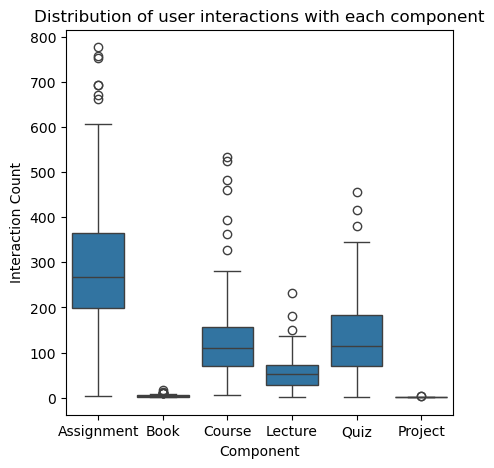

In [7]:
app = ApplicationBase()
app.root.mainloop()